In [1]:
from qiskit.circuit.library import TwoLocal, ZZFeatureMap
from qiskit_machine_learning.optimizers import COBYLA
from qiskit_machine_learning.utils import algorithm_globals

from qiskit_machine_learning.algorithms import VQC
from qiskit_machine_learning.datasets import ad_hoc_data

seed = 1376
algorithm_globals.random_seed = seed

# Use ad hoc data set for training and test data
feature_dim = 2  # dimension of each data point
training_size = 20
test_size = 10

# training features, training labels, test features, test labels as np.ndarray,
# one hot encoding for labels
training_features, training_labels, test_features, test_labels = ad_hoc_data(
    training_size=training_size, test_size=test_size, n=feature_dim, gap=0.3
)

feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=2, entanglement="linear")
ansatz = TwoLocal(feature_map.num_qubits, ["ry", "rz"], "cz", reps=3)
vqc = VQC(
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=COBYLA(maxiter=100),
)
vqc.fit(training_features, training_labels)

score = vqc.score(test_features, test_labels)
print(f"Testing accuracy: {score:0.2f}")

Testing accuracy: 0.90


## classification

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_machine_learning.optimizers import COBYLA, L_BFGS_B
from qiskit_machine_learning.utils import algorithm_globals

from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.circuit.library import QNNCircuit

algorithm_globals.random_seed = 42

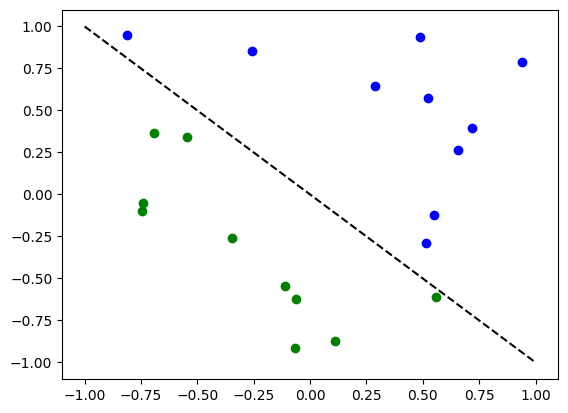

In [3]:
num_inputs = 2
num_samples = 20
X = 2 * algorithm_globals.random.random([num_samples, num_inputs]) - 1
y01 = 1 * (np.sum(X, axis=1) >= 0)  # in { 0,  1}
y = 2 * y01 - 1  # in {-1, +1}
y_one_hot = np.zeros((num_samples, 2))
for i in range(num_samples):
    y_one_hot[i, y01[i]] = 1

for x, y_target in zip(X, y):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()



 SamplerQNN can be used for classification within a NeuralNetworkClassifier. In this context, the SamplerQNN is expected to return $d$-dimensional probability vector as output, where $d$ denotes the number of classes. The underlying Sampler primitive returns quasi-distributions of bit strings and we just need to define a mapping from the measured bitstrings to the different classes. For binary classification we use the parity mapping.

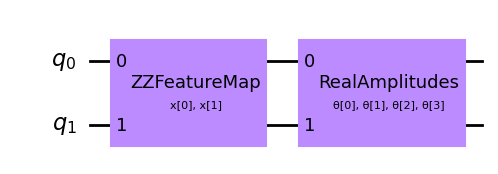

In [4]:
# construct a quantum circuit from the default ZZFeatureMap feature map and a customized RealAmplitudes ansatz
qc = QNNCircuit(ansatz=RealAmplitudes(num_inputs, reps=1))
qc.draw("mpl", style="clifford")

In [5]:
# parity maps bitstrings to 0 or 1
def parity(x):
    return "{:b}".format(x).count("1") % 2

output_shape = 2  # corresponds to the number of classes, possible outcomes of the (parity) mapping.

In [6]:
from qiskit.primitives import StatevectorSampler as Sampler

sampler = Sampler()
# construct QNN
sampler_qnn = SamplerQNN(
    circuit=qc,
    interpret=parity,
    output_shape=output_shape,
    sampler=sampler,
)

No gradient function provided, creating a gradient function. If your Sampler requires transpilation, please provide a pass manager.


In [9]:
objective_func_vals = []

In [10]:
# callback function that draws a live plot when the .fit() method is called
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [11]:
# construct classifier
sampler_classifier = NeuralNetworkClassifier(
    neural_network=sampler_qnn, optimizer=COBYLA(maxiter=30), callback=callback_graph
)

In [12]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
sampler_classifier.fit(X, y01)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
sampler_classifier.score(X, y01)

0.7

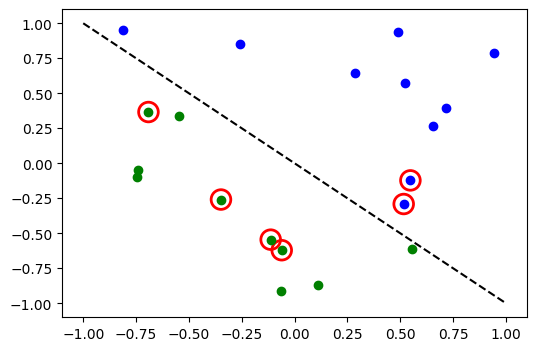

In [13]:
# evaluate data points
y_predict = sampler_classifier.predict(X)

# plot results
# red == wrongly classified
for x, y_target, y_p in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
    if y_target != y_p:
        plt.scatter(x[0], x[1], s=200, facecolors="none", edgecolors="r", linewidths=2)
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()

In [14]:
sampler_classifier.weights

array([1.78072635, 2.19624799, 0.91111941, 1.40530205])